In [2]:
%matplotlib notebook
from scipy import *
from pylab import *
import glob
from datetime import *

from sympy import *
from numpy import *
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from scipy import optimize
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

from scipy.optimize import leastsq
import os
import pandas as pd
import matplotlib.font_manager as fm
font_names = [f.name for f in fm.fontManager.ttflist]
mpl.rcParams['font.family'] = 'Times'
mpl.rcParams['mathtext.fontset'] = 'custom'
# mpl.rcParams['mathtext.rm'] = 'Times'
mpl.rcParams['mathtext.it'] = 'Times:italic'
mpl.rcParams['mathtext.bf'] = 'Times'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.formatter.limits'] = [-5,5]

In [3]:
def get_files():
    os.chdir('/home/henry/Documents/Physics Internship/Transmission/')
    files= glob.glob('*.txt')
    files = sorted(files,reverse=True)
    return files

In [4]:
def convert_to_mW(input_list):
    converted_list = (10**(input_list/10))/1000
    return converted_list

In [5]:
def get_powers(file_names):
    powers = [get_power(file_name) for file_name in file_names]
    return powers

In [6]:
def get_power(file_name):
    power = file_name[26:30]
    power = round(float(power), 1)
    return power

In [7]:
def get_raw_data(file):
    with open(file,'r') as f:
        data=f.readlines()
    return data

In [8]:
def get_voltage_and_frequency(data):
    data_fields = [[float(number) for number in line.strip().split('\t')]
                   for line in data[1:]]
    voltage, frequency = zip(*data_fields)
    return array(voltage), array(frequency)

In [9]:
def get_S21(voltage, power):
    power_mW = convert_to_mW(power)
    S21 = voltage/power_mW
    return S21

In [10]:
def get_S21_normalised(S21_list, index_maxima):
    S21_normalised = [S21/S21[index] for S21, index in zip(S21_list, index_maxima)]
    return S21_normalised

In [11]:
def get_index_maximum(frequency, voltage):
    voltage = get_moving_average(voltage, 4)
    max_index = argmax(array(voltage))
    return max_index

def get_moving_average(points, window_width):
    N = len(points)
    window_points = [[points[inside_window(i+j, N)] for i in range(window_width)]
                     for j in range(N)]
    moving_average = [sum(window)/window_width for window in window_points]
    return moving_average

def inside_window(i, N):
    if i < 0:
        return 0
    elif i > N-1:
        return N-1
    return i

In [12]:
def offset_frequency(frequency, min_index, max_index):
    frequency = frequency[0:len(frequency) - (max_index - min_index)]
    resonant_frequency = frequency[min_index]
    frequency -= resonant_frequency
    return frequency

In [13]:
def get_S21_offset_list(S21_list, min_index, max_index):
    S21_offset_list = [get_S21_offset(S21, index, min_index, max_index)
                       for S21, index in zip(S21_list, index_maxima)]
    return S21_offset_list

In [14]:
def get_S21_offset(S21, index, min_index, max_index):
    left_index = index - min_index
    right_index = len(S21) - (max_index - index)
    S21_offset = S21[left_index:right_index]
    return S21_offset

In [28]:
def create_figure_1(S21_list, filter_rate):
    for index, S21 in enumerate(S21_list):
        if index % filter_rate == 0:
            plot_figure_1(frequency, S21)
    plt.title("Shape of $|S_{21}|^2$ against frequency\nfor various power levels")
    plt.xlim(-2*10**7, 2*10**7)
    x_ticks = plt.xticks()[0]
    x_labels = [f'{value:.0f}' for value in plt.xticks()[0]/10**6]
    plt.xticks(x_ticks, x_labels)
    plt.savefig('/home/henry/Documents/Physics Internship/test',
                bbox_inches='tight', format='svg')

def plot_figure_1(frequency, voltage):
    figure(1)
    plt.plot(frequency, voltage,'-',alpha=1)
    plt.xlabel('${\omega_c}$ (MHz)')
    plt.ylabel('Amplitude')

In [16]:
def get_colourmap():
    viridis = plt.cm.RdBu_r(np.linspace(0.0,1, 256))
    all_colors = np.vstack((viridis))
    colourmap = colors.LinearSegmentedColormap.from_list('colours',all_colors)
    return colourmap

In [17]:
def set_x_ticks(ax):
    x_ticks, x_labels = get_x_ticks_and_labels()
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(labels=x_labels, rotation=30, ha='right', rotation_mode="anchor")
    return ax

def get_x_ticks_and_labels():
    def get_x_tick(x_label):
            x_tick = (x_label-frequency_min)/(frequency_max-frequency_min)*scale_range
            return x_tick

    frequency_max, frequency_min = max(frequency), min(frequency)
    scale_range = len(S21_big[0])
    x_labels = linspace(-10000000, 30000000, 5)
    x_ticks = [get_x_tick(x_label) for x_label in x_labels]
    x_labels = [f'{x_label/10**6:.0f}' for x_label in x_labels]
    return x_ticks, x_labels

In [18]:
def set_y_ticks(ax):
    y_ticks, y_labels = get_y_ticks_and_labels()
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    return ax

def get_y_ticks_and_labels():
    def get_y_tick(y_label):
            y_tick = (power_max-y_label)/(power_max-power_min)*scale_range
            return y_tick

    power_max, power_min = max(powers), min(powers)
    scale_range = len(S21_big)
    y_labels = linspace(26, 29, 7)
    y_ticks = [get_y_tick(y_label) for y_label in y_labels]
    return y_ticks, y_labels

In [19]:
def set_axis_labels(ax1, width):
    ax1 = set_x_ticks(ax1)
    ax1 = set_y_ticks(ax1)
    ax1.set_xlim((0, width))
    ax1.set_xlabel('Frequency (MHz)')
    ax1.set_ylabel('Input Power (dBm)')
    return ax1

<IPython.core.display.Javascript object>


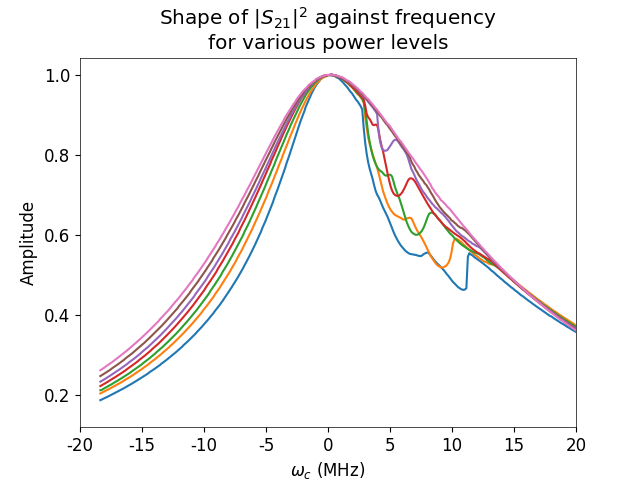

findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font f

In [29]:
files = get_files()
powers = get_powers(files)
S21_list = []
index_maxima = []

for file, power in zip(files, powers):
    raw_data = get_raw_data(file)
    voltage, frequency = get_voltage_and_frequency(raw_data)
    voltage = convert_to_mW(voltage)
    index_maximum = get_index_maximum(frequency, voltage)
    S21_list.append(get_S21(voltage, power))
    index_maxima.append(index_maximum)

S21_list = get_S21_normalised(S21_list, index_maxima)
min_index = min(index_maxima)
max_index = max(index_maxima)
frequency = offset_frequency(frequency, min_index, max_index)
S21_offset_list = get_S21_offset_list(S21_list, min_index, max_index)
S21_big = [S21 for S21 in S21_offset_list for i in range(11)]

create_figure_1(S21_offset_list, 5)

<IPython.core.display.Javascript object>


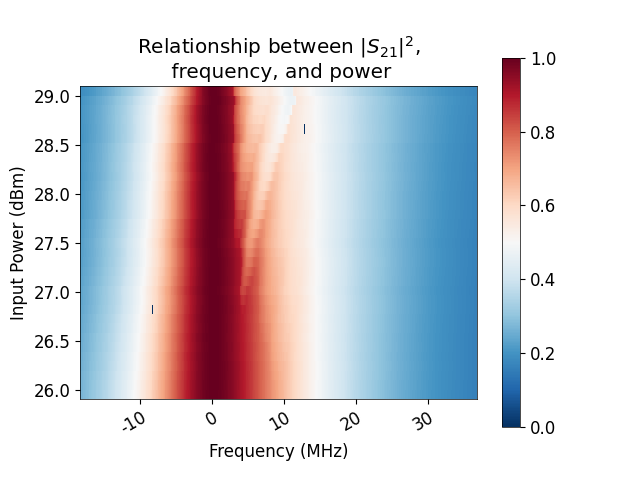

findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font f

In [30]:
fig, (ax1) = plt.subplots(1,1)
colourmap = get_colourmap()
divnorm = colors.TwoSlopeNorm(vmin=0.000, vcenter=0.5, vmax=1)
pc = ax1.pcolormesh(S21_big, rasterized = True, norm = divnorm, cmap = colourmap)
ax1 = set_axis_labels(ax1, len(S21_big[0]))
cbar = fig.colorbar(pc)
ax1.set_title("Relationship between $|S_{21}|^2$,\n frequency, and power")

im1 = ax1.imshow(S21_big)
plt.show()
fig.savefig('/home/henry/Documents/Physics Internship/test', bbox_inches='tight', format='svg')